# Exercício 3 - Algotrading

**Antonio Fuziy**

___

### Lista: Exercício 3 - 16/Mai até 9h30

* Modificar a ideia 1 da aula de hoje para simular pares de até 3 ações americanas correlacionadas.
* Selecionar entre 1 ano e 2 anos de dados
* Precisa ajustar as quantidades para que tenham o mesmo valor financeiro. As quantidades serão inteiros múltiplos de 1.
* Entregar um **PDF** com o código e o gráfico da simulação do resultado
* Prazo: 16/Mai até 9h30 via Blackboard (Após esse prazo será considerado atrasado)
* Estritamente individual

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import time
from datetime import datetime
import random
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller
import yahoofinancials as yf

from backtesting_v2_1 import TradingSystem, MarketData, Order, Strategy, Event, evaluateHist

In [2]:
# tickers = ['NKE', "NKE.DE", "BPAC11.SA", "XP"]

# start_date = '2021-05-10'
# end_date =  '2022-05-10'

# for ticker in tickers:
#     data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

#     # Ler os dados do JSON
#     raw = pd.DataFrame(data[ticker]['prices']).dropna()
#     # Converter a data para o tipo correto datetime
#     raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
#     # Indica a data como o índice de cada linha
#     raw = raw.set_index('formatted_date')
#     # Removendo as colunas que não interessam
#     df = raw.iloc[:,1:]

#     # Acertando a ordem das colunas
#     df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
#     # Salvando o CSV
#     df.to_csv('{}.csv'.format(ticker))

In [3]:
# df1 = pd.read_csv('NKE.csv')
# df2 = pd.read_csv('ADDYY.csv')
ticker1 = "MGLU3.SA"
ticker2 = "SUZB3.SA"

In [4]:
df1 = pd.read_csv(f'{ticker1}.csv')
df2 = pd.read_csv(f'{ticker2}.csv')

In [5]:
df1.set_index('formatted_date')
df2.set_index('formatted_date')

,open,high,low,close,adjclose,volume
formatted_date,,,,,,
2018-05-10,42.549999,43.349998,41.619999,42.020000,38.629807,4827600
2018-05-11,41.779999,43.849998,41.200001,43.099998,39.622669,3836300
2018-05-14,43.000000,45.279999,42.950001,45.250000,41.599209,4926200
2018-05-15,47.209999,47.840000,45.650002,45.990002,42.279503,6523300
2018-05-16,46.389999,46.900002,43.919998,44.490002,40.900528,4258800
...,...,...,...,...,...,...
2020-05-04,38.730000,40.500000,38.389999,40.500000,38.050106,6603500
2020-05-05,40.619999,41.900002,39.630001,41.599998,39.083565,8171000
2020-05-06,41.779999,42.490002,40.619999,41.869999,39.337234,6586200


In [6]:
df_join_ = df1.join(df2, how='inner', lsuffix='_df1', rsuffix='_df2')
df_join_

,formatted_date_df1,open_df1,high_df1,low_df1,close_df1,adjclose_df1,volume_df1,formatted_date_df2,open_df2,high_df2,low_df2,close_df2,adjclose_df2,volume_df2
0,2018-05-10,3.519687,3.578125,3.421875,3.421875,3.310558,61299200,2018-05-10,42.549999,43.349998,41.619999,42.020000,38.629807,4827600
1,2018-05-11,3.421875,3.474687,3.334375,3.395312,3.284859,46371200,2018-05-11,41.779999,43.849998,41.200001,43.099998,39.622669,3836300
2,2018-05-14,3.425000,3.458750,3.294062,3.379687,3.269743,47523200,2018-05-14,43.000000,45.279999,42.950001,45.250000,41.599209,4926200
3,2018-05-15,3.379687,3.454375,3.306250,3.327187,3.218951,53561600,2018-05-15,47.209999,47.840000,45.650002,45.990002,42.279503,6523300
4,2018-05-16,3.314062,3.569687,3.314062,3.506562,3.392490,68899200,2018-05-16,46.389999,46.900002,43.919998,44.490002,40.900528,4258800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2020-05-04,12.000000,12.920000,11.827500,12.860000,12.762948,52352400,2020-05-04,38.730000,40.500000,38.389999,40.500000,38.050106,6603500
489,2020-05-05,13.037500,13.200000,12.537500,12.550000,12.455288,51550000,2020-05-05,40.619999,41.900002,39.630001,41.599998,39.083565,8171000
490,2020-05-06,13.055000,14.020000,13.005000,13.787500,13.683450,119365600,2020-05-06,41.779999,42.490002,40.619999,41.869999,39.337234,6586200
491,2020-05-07,14.125000,14.550000,13.347500,14.197500,14.090353,92667200,2020-05-07,43.520000,47.799999,43.000000,45.009998,42.287292,22747000


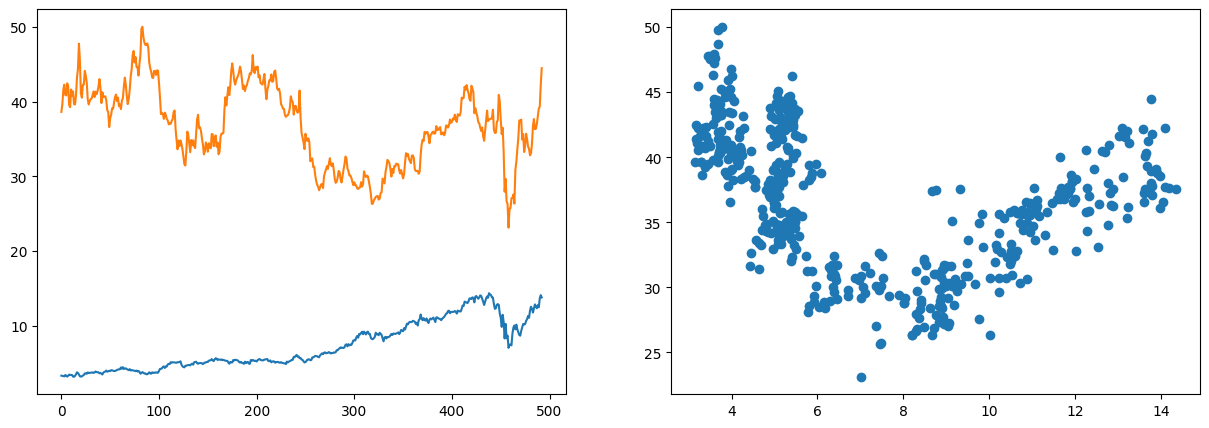

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df_join_.adjclose_df1);
plt.plot(df_join_.adjclose_df2);

plt.subplot(1, 2, 2)
plt.scatter(df_join_.adjclose_df1, df_join_.adjclose_df2);
plt.show()

In [8]:
spearmanr(df_join_.adjclose_df1, df_join_.adjclose_df2)

SignificanceResult(statistic=-0.4790915315128398, pvalue=1.1791366845121657e-29)

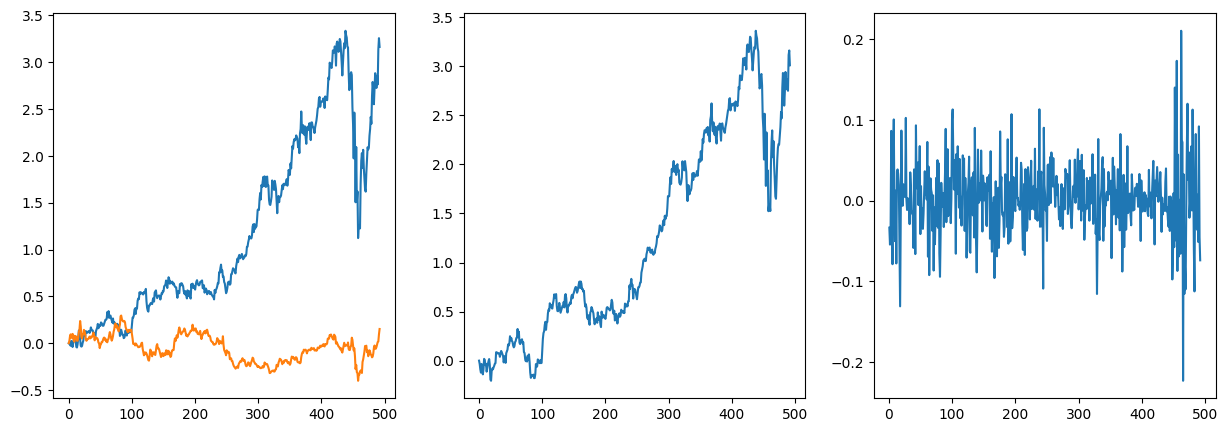

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ret_df1 = df_join_.adjclose_df1/df_join_.adjclose_df1[0]-1
plt.plot(ret_df1);
ret_df2 = df_join_.adjclose_df2/df_join_.adjclose_df2[0]-1
plt.plot(ret_df2);

plt.subplot(1, 3, 2)
plt.plot(ret_df1-ret_df2);

plt.subplot(1, 3, 3)
df_join_['diff'] = df_join_.adjclose_df1.pct_change()-df_join_.adjclose_df2.pct_change()
df_join_ = df_join_.dropna()
plt.plot(df_join_['diff']);

plt.show()

In [10]:
adf, pvalue, *_ = adfuller(df_join_['diff'])
print(pvalue)

0.0


In [11]:
metrics = df_join_['diff'].describe()

In [12]:
df_join_diff = pd.DataFrame({'formatted_date': df_join_['formatted_date_df1'],
                    'open': df_join_['open_df1'],
                    'high': df_join_['high_df1'],
                    'low': df_join_['low_df1'],
                    'close': df_join_['close_df1'],
                    'adjclose': df_join_['diff'],
                    'volume': 0,
                   })
df_join_diff = df_join_diff.set_index('formatted_date')
df_join_diff

,open,high,low,close,adjclose,volume
formatted_date,,,,,,
2018-05-11,3.421875,3.474687,3.334375,3.395312,-0.033465,0
2018-05-14,3.425000,3.458750,3.294062,3.379687,-0.054486,0
2018-05-15,3.379687,3.454375,3.306250,3.327187,-0.031888,0
2018-05-16,3.314062,3.569687,3.314062,3.506562,0.086527,0
2018-05-17,3.506250,3.544062,3.357187,3.417187,-0.023914,0
...,...,...,...,...,...,...
2020-05-04,12.000000,12.920000,11.827500,12.860000,0.007352,0
2020-05-05,13.037500,13.200000,12.537500,12.550000,-0.051266,0
2020-05-06,13.055000,14.020000,13.005000,13.787500,0.092115,0


In [13]:
df_join_diff.to_csv('df_join_diff.csv')

In [15]:
class LongShort(Strategy):
    
    def __init__(self, uband, lband, ticker1, ticker2):
        self.prices = []
        self.indicator = []
        
        self.prices1 = []
        self.prices2 = []
        
        self.side = 0
        
        self.qty1 = 0
        self.qty2 = 0
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        self.price1 = 1
        self.price2 = 1
        self.multiple = 1
        
        self.uband = uband
        self.lband = lband
        
    def receive(self, event):
        
        orders = []
        
        if event.instrument == self.ticker1:
            self.prices1.append(event.price[3])
            self.price1 = event.price[3]
            
        if event.instrument == self.ticker2:
            self.prices2.append(event.price[3])
            self.price2 = event.price[3]
        
        if event.instrument == 'df_join_diff':

            price = event.price[3] # Captura o spread

            # Montando a série de preços:
            self.prices.append(price)
            
            signal = self.side

            if price > self.uband:
                signal = -1 # Sell PETR3, buy PETR4
            elif price < self.lband:
                signal = 1 # Buy PETR3, sell PETR4

            if self.side != signal:
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.S, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                
                # Zeragem ticker2:
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.S, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                
                # Vamos user o mesmo tamanho porque eles tem preços semelhantes!
                # Mas não é o ideal!
                
                if self.price1 >= self.price2:
                    self.multiple = int(self.price1 / self.price2)
                    self.qty2 = 200 * signal * self.multiple
                    self.qty1 = -int(200 * signal)

                elif self.price1 < self.price2:
                    self.multiple = int(self.price2 / self.price1)
                    self.qty1 = 200 * signal
                    self.qty2 = -int(200 * signal) * self.multiple
                    
#                 print("PRICE 1: ", self.price1)
#                 print("PRICE 2: ", self.price2)
#                 print("MULTIPLE: ", self.multiple)
                    
                
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.SS, self.qty1, 0))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.SS, self.qty2, 0))

                self.side = signal
        return orders
    
    def fill(self, id, instrument, price, quantity, status):
        
        # Imprimindo o preenchimento das ordens
        if quantity != 0:
            print('Fill: {0} {1}@{2}'.format(instrument, quantity, price))
        
    
    
model = LongShort(metrics[4], metrics[6], ticker1, ticker2)
print(evaluateHist(model, {ticker1: f'{ticker1}.csv', ticker2: f'{ticker2}.csv', 'df_join_diff': 'df_join_diff.csv'}))

Fill: MGLU3.SA 200@3.2848594188690186
Fill: SUZB3.SA -2400@39.6226692199707
Fill: MGLU3.SA -200@3.3924899101257324
Fill: SUZB3.SA 2400@40.90052795410156
Fill: MGLU3.SA -200@3.3924899101257324
Fill: SUZB3.SA 2400@40.90052795410156
Fill: MGLU3.SA 200@3.3060226440429688
Fill: SUZB3.SA -2400@40.83616638183594
Fill: MGLU3.SA 200@3.3060226440429688
Fill: SUZB3.SA -2400@40.83616638183594
Fill: MGLU3.SA -200@3.31146502494812
Fill: SUZB3.SA 2400@42.03128433227539
Fill: MGLU3.SA -200@3.31146502494812
Fill: SUZB3.SA 2400@42.03128433227539
Fill: MGLU3.SA 200@3.416071891784668
Fill: SUZB3.SA -2400@41.62678146362305
Fill: MGLU3.SA 200@3.416071891784668
Fill: SUZB3.SA -2400@41.62678146362305
Fill: MGLU3.SA -200@3.386141777038574
Fill: SUZB3.SA 2400@40.74423599243164
Fill: MGLU3.SA -200@3.386141777038574
Fill: SUZB3.SA 2400@40.74423599243164
Fill: MGLU3.SA 200@3.1745080947875977
Fill: SUZB3.SA -2400@41.369380950927734
Fill: MGLU3.SA 200@3.1745080947875977
Fill: SUZB3.SA -2600@41.369380950927734
Fill: 